Problem Statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Importing Skin Cancer Data**

**To do:** Take necessary actions to read the data

**Importing all the important libraries**

In [7]:
import numpy as np
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("gdrive/My Drive/skin_cancer/Train/")
data_dir_test = pathlib.Path('gdrive/My Drive/skin_cancer/Test/')

In [9]:
# get the count of train and test images.
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)
     

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [10]:
# parameters predefine for the loader
batch_size = 32
img_height = 180
img_width = 180
     

Use 80% of the images for training, and 20% for validation.



In [11]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# create training dataset --> we see that 1792 images are considered for training out of 2239. 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    seed=123,
    validation_split = 0.2,
    subset='training'
    )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [18]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# create validation dataset - 447 images are considered for validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    seed=123,
    validation_split = 0.2,
    subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
# there are 9 classes in the training dataset.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

**Todo:** create a code to visualize one instance of all the nine classes present in the dataset

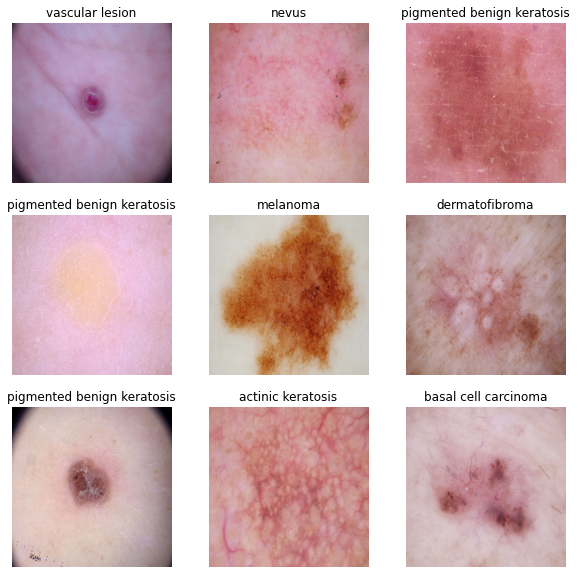

In [13]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

# plot the sample image of each of the skin cancers
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
# check the shape of the image and label
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [19]:
# optimze the  model for better performance.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
     

**Create the model**

**Todo:** Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [20]:
# create a model with convolution layers,pooling layers, flatten and dense layers. Since we are using sparse categorical cross entropy as the loss function we are not using sigmoid.

num_classes = 9 # As target class has 9 labels

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3), offset=0.0,),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [21]:
### Todo, choose an appropirate optimiser and loss function
# have chosen the optimizer as adam and lossfunction as sparse categorical crossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
     

In [22]:
# View the summary of all layers
# we see that 3,989,801 trainable parameters are generated for this model. 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

**Train the model**

Fit the model for traind and validation data with 20 epochs

In [23]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 273s 1s/step - loss: 1.8952 - accuracy: 0.3097 - val_loss: 1.6999 - val_accuracy: 0.4474
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.6008 - accuracy: 0.4263 - val_loss: 1.4498 - val_accuracy: 0.5123
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4115 - accuracy: 0.5078 - val_loss: 1.4555 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3177 - accuracy: 0.5424 - val_loss: 1.3470 - val_accuracy: 0.5391
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1927 - accuracy: 0.5820 - val_loss: 1.3232 - val_accuracy: 0.5593
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1341 - accuracy: 0.6032 - val_loss: 1.3747 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.0687 - accuracy: 0.6278 - val_loss: 1.4448 - val_accuracy: 0.5324
Epoch 8/20
56

**Visualizing training results**

Create the train vs validation accuracu and loss function plots.

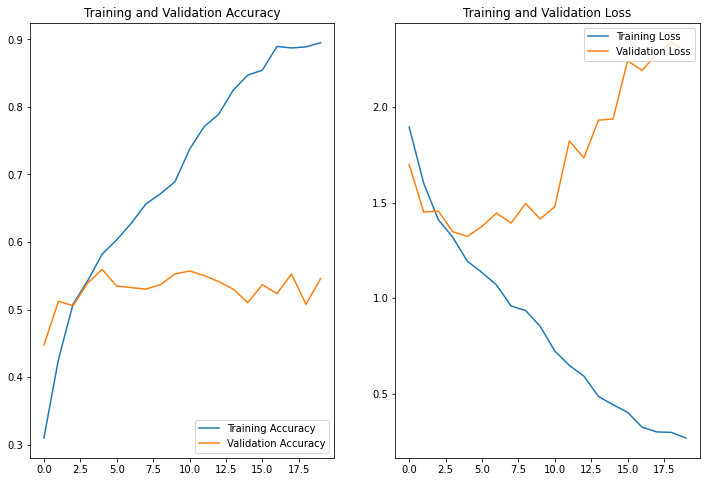

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
     

**Todo:** Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Observation:



*   The accuracy of the model for the Training data set is 89.51%. But the Validation accuracy between 54.59% only.


*   The validation loss as observed is very high. For training the loss is less than 0.2680 where are for validation the loss is 2.2919.


*   This shows that the model is overfitting.







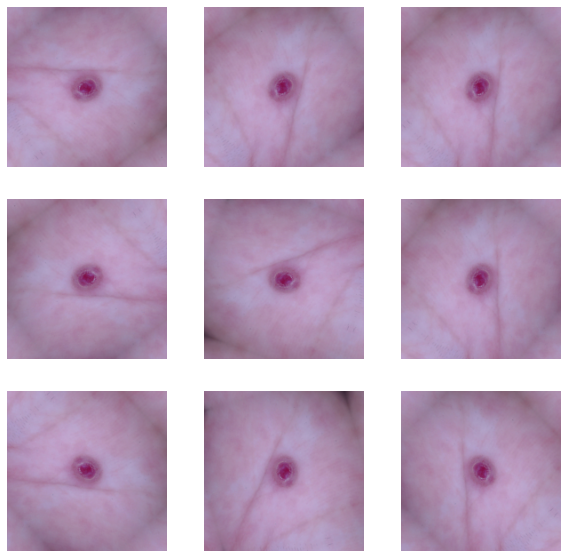

In [26]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# using horizontal and vertical fippling data augumentaion with bit of rotation. 
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

# plot one of the augumented image to see the different versions of it. 
image, label = next(iter(train_ds))

image = np.array(image,np.int32)
plt.figure(figsize=(10,10))

for i in range(9):
  augmented_image = data_augmentation(images)
  ax = plt.subplot(3, 3, i + 1)
  augumented_image1 = np.array(augmented_image[0],np.int32)
  plt.imshow(augumented_image1)
  plt.axis('off')

**Todo:** Create the model, compile and train the model

In [27]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
## create a model with data augumentation.

num_classes = 9 # As target class has 9 labels

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3),offset=0.0,),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


**Compiling the model**


In [28]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
# View the summary of all layers
# we see that 3,989,801 trainable parameters are generated for this model. 
model.summary()
     

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

**Training the model**


In [30]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 51ms/step - loss: 2.0741 - accuracy: 0.2054 - val_loss: 1.9421 - val_accuracy: 0.2685
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.7839 - accuracy: 0.3700 - val_loss: 1.7881 - val_accuracy: 0.4430
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.5780 - accuracy: 0.4470 - val_loss: 1.5772 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4827 - accuracy: 0.4961 - val_loss: 1.4266 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3800 - accuracy: 0.5190 - val_loss: 1.3568 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3922 - accuracy: 0.5151 - val_loss: 1.4566 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.3300 - accuracy: 0.5424 - val_loss: 1.3553 - val_accuracy: 0.5459
Epoch 8/20
56

**Visualizing the results**


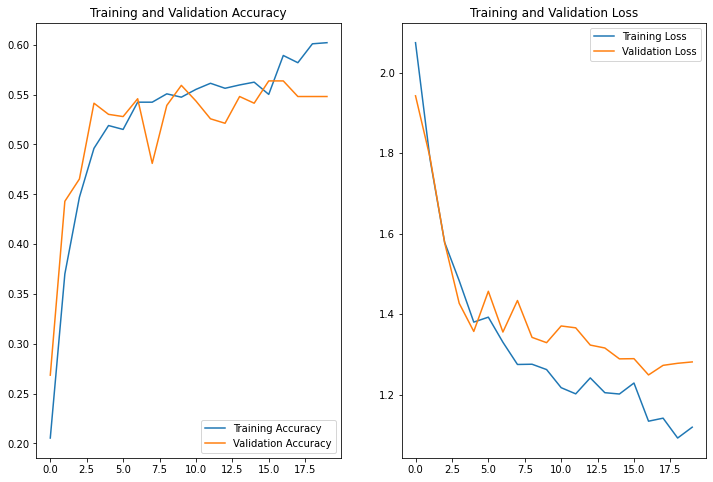

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo:** Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?



*   We see that both training and validation accuracy and loss is almost similary i.e., 60.21% and 54.81% and 1.1189 to 1.28 respectively. We dont see high accuracy of the model. They are underfitting as they are not able to perform well on the given dataset.



*   We need to relook at the data and then train the model.


**Todo:** Find the distribution of classes in the training dataset.

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.





In [33]:
## Your code goes here.

# get the count of images in each of the class. 

for i in class_names:
    directory =str(data_dir_train)+'/'+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

     

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


**Todo:** Write your findings here:

- Which class has the least number of samples?
  Ans: seborrheic keratosis 

- Which classes dominate the data in terms proportionate number of samples?
Ans: pigmented benign keratosis 



**Todo:** Rectify the class imbalance

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [34]:
!pip install Augmentor


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.

2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [35]:
path_to_training_dataset=str(data_dir_train)+'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/skin_cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5D17B48B50>: 100%|██████████| 500/500 [00:18<00:00, 27.13 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5D17C3EDF0>: 100%|██████████| 500/500 [00:20<00:00, 24.56 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/skin_cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5D17C24B80>: 100%|██████████| 500/500 [00:20<00:00, 24.88 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/skin_cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5D14F039A0>: 100%|██████████| 500/500 [01:27<00:00,  5.74 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/skin_cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F5D919BE310>: 100%|██████████| 500/500 [01:22<00:00,  6.10 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5D1783E430>: 100%|██████████| 500/500 [00:19<00:00, 25.61 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5D17818A00>: 100%|██████████| 500/500 [00:45<00:00, 11.03 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5D146E7F70>: 100%|██████████| 500/500 [00:19<00:00, 26.06 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/skin_cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5D17BF7DF0>: 100%|██████████| 500/500 [00:18<00:00, 27.05 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

We see that there are total 4500 new augumented images that we generated by the augmentor

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

We see that there is a new output folder created under each class which has the new images that we generated.

In [37]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list
     

['gdrive/My Drive/skin_cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027488.jpg_63cb2c69-a810-4909-af2b-7786fbe821a8.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031735.jpg_f8707011-bfc1-4204-9137-6fd1ee490250.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033810.jpg_a441bc3c-8811-474e-97bb-f6495a66303c.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029039.jpg_f41191a0-9558-480e-9890-ac7e6c849c77.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027745.jpg_2f71e4b3-4a6f-4122-bb21-756bbd32eebb.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026789.jpg_13e4d086-9b29-4499-ae7a-d75432b76cc9.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025622.jpg_e9d2e7f2-7e6d-4648-ae24-831ed6d4dee9.jpg',
 'gdri

Get the folders/class names where the new images were generated in output folder



In [38]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

Create a dictionary that contains the path and the label for each of the image generated in output folder.



In [39]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


Get the count of the images under each class post augumentation.



In [40]:
for i in class_names:
    directory =str(data_dir_train)+'/'+i+'/'
    directory_out =str(data_dir_train)+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


Get the list of the original path of the images



In [41]:
import glob
path_list_orig = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_orig

['gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0030830.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0032941.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0031257.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0033790.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0025903.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0029962.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0026417.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0032468.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0028735.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0026254.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0025302.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0025504.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0027598.jpg',
 'gdrive/My Drive/skin_cancer/Train/dermatofibroma/ISIC_0031271.jpg',
 'gdrive/My Drive/sk

Get the label for the original images



In [42]:
lesion_list_orig = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_orig

['Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',
 'Train',


Create a dataframe with original images and their labels.



In [43]:
original_dict = dict(zip(path_list_orig, lesion_list_orig))
original_df = pd.DataFrame(list(original_dict.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,gdrive/My Drive/skin_cancer/Train/dermatofibro...,Train
1,gdrive/My Drive/skin_cancer/Train/dermatofibro...,Train
2,gdrive/My Drive/skin_cancer/Train/dermatofibro...,Train
3,gdrive/My Drive/skin_cancer/Train/dermatofibro...,Train
4,gdrive/My Drive/skin_cancer/Train/dermatofibro...,Train


Create a new datafram that has both the original images and augmented images.



In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [45]:
new_df['Label'].value_counts()


Train                         2239
dermatofibroma                 500
seborrheic keratosis           500
vascular lesion                500
melanoma                       500
pigmented benign keratosis     500
actinic keratosis              500
basal cell carcinoma           500
nevus                          500
squamous cell carcinoma        500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.



In [46]:
new_df.head()


,Path,Label
0,gdrive/My Drive/skin_cancer/Train/dermatofibro...,Train
1,gdrive/My Drive/skin_cancer/Train/dermatofibro...,Train
2,gdrive/My Drive/skin_cancer/Train/dermatofibro...,Train
3,gdrive/My Drive/skin_cancer/Train/dermatofibro...,Train
4,gdrive/My Drive/skin_cancer/Train/dermatofibro...,Train


Total count of images.



In [47]:
new_df['Path'].count()


6739

**Todo:** Train the model on the data created using Augmentor
define the parameters for the model.

In [48]:
batch_size = 32
img_height = 180
img_width = 180
     

**Todo:** Create a training dataset
There are total 6739 images out of which 5392 is considered for training data.

In [49]:
data_dir_train= pathlib.Path("gdrive/My Drive/skin_cancer/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Todo:** Create a validation dataset
around 1347 images are considered as validation set.

In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Todo:** Create your model (make sure to include normalization)
create the model post handing class imbalance.

In [51]:
## your code goes here

### Your code goes here
num_classes = 9 # As target class has 9 labels

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3),offset=0.0,),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.1),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Todo:** Compile your model (Choose optimizer and loss function appropriately)

Compile the model and print the summary

In [52]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

**Todo:** Train your model


In [54]:
# setting epochs to 20 as per evaluation rubic. 
epochs = 20
## Your code goes here, use 20 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 31s 178ms/step - loss: 1.8794 - accuracy: 0.2888 - val_loss: 1.5614 - val_accuracy: 0.4202
Epoch 2/20
169/169 [==============================] - 31s 176ms/step - loss: 1.3935 - accuracy: 0.4759 - val_loss: 1.3205 - val_accuracy: 0.4996
Epoch 3/20
169/169 [==============================] - 31s 179ms/step - loss: 1.1730 - accuracy: 0.5623 - val_loss: 1.1104 - val_accuracy: 0.5917
Epoch 4/20
169/169 [==============================] - 31s 176ms/step - loss: 0.9925 - accuracy: 0.6387 - val_loss: 1.0722 - val_accuracy: 0.5991
Epoch 5/20
169/169 [==============================] - 32s 185ms/step - loss: 0.8362 - accuracy: 0.6971 - val_loss: 0.9469 - val_accuracy: 0.6785
Epoch 6/20
169/169 [==============================] - 31s 177ms/step - loss: 0.6755 - accuracy: 0.7561 - val_loss: 0.8324 - val_accuracy: 0.7075
Epoch 7/20
169/169 [==============================] - 31s 177ms/step - loss: 0.5584 - accuracy: 0.8036 - val_loss: 0.9181 - val_ac

**Todo:** Visualize the model results

plot the train vs validation accurracy and loss

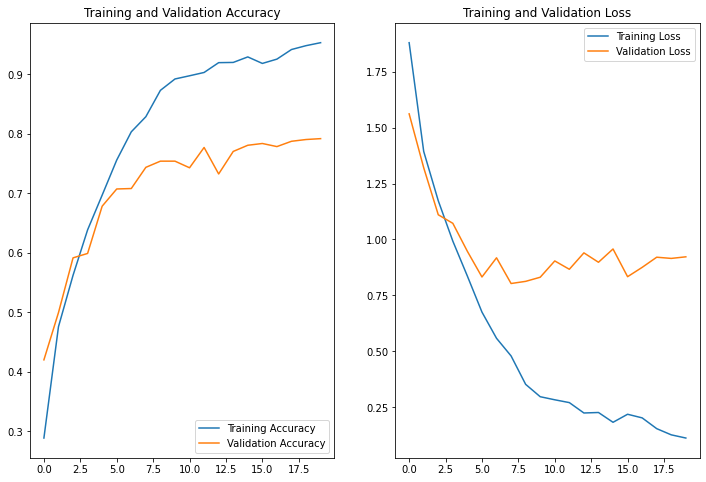

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo:** Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Note:

The final model has been built with 20 epochs as per the evaluation rubic page the assignment. 

Observations:

The model starts building overfitting with 95 percent training accuracy



So we can conclude that class imbalance helped in improving the model performance with 3 convolution layers, pooling layers, flatten and dense layers. So the final model will be the as per the observation 1.